# Introduction
The goal of this notebook is to model an item-to-item collaborative filter, that, for a given item, recommends other items that share the same viewers. 

*Data*
- EventId -- A unique identifier for this event in the form of a SHA256 hash
- MediaId -- A unique identifier for watched Media items as an integer
- UserId -- A unique identifier for a user-account as an integer
- Timestamp -- A Unix/POSIX Epoch time representation of the client-side time
- DateTime -- An ISO-8601 formatted representation of the client-side time
- EventType -- The type of view-event send to the server
    - waypoint -- denoting a 30 seconds watched interval
    - streamstart -- denoting the start of a stream
    - streamstop -- denoting a client-initiated stop of stream
    - streamend -- denoting the end of the media item is reached, should occur once for each user-
item combination

In [3]:
from collections import Counter
import gzip
import joblib
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import timeit

pd.options.mode.chained_assignment = None

FONTSIZE = 15
LOCAL_PATH = 'data/'
FILE_PATH = LOCAL_PATH + "noisy_mock_events.gz"

# Process stream events
The following steps were done to process the data:
- Read data and store as pd.DataFrame.
- Group by user and items, aggregate the streamlength.
- Filter streams that don't contain atreamStart and atreamStop, because atreamStop is when client stops the stream and is thus related to user interaction.  

In [7]:
# get keys
with gzip.open(FILE_PATH, "r") as events_file:
    while line := events_file.readline():
        event = json.loads(line)
        # discard EventId
        keys = list(event.keys())[1:]
        break

# get values
collab_raw_timeseries = []

start_time = timeit.default_timer()

with gzip.open(FILE_PATH, "r") as events_file:
    while line := events_file.readline():
        event = json.loads(line)
        # discard EventId values
        collab_raw_timeseries.append(list(event.values())[1:])

print(f'Took {timeit.default_timer()-start_time:.2f} seconds.')

df = pd.DataFrame(collab_raw_timeseries, columns = keys)

Took 51.55 seconds.


# Preprocessing

In [9]:
# Incorrect types: Timestamp is int, and UserId is string. 
df.dtypes

UserId       object
MediaId       int64
Timestamp     int64
DateTime     object
EventType    object
dtype: object

In [10]:
print("Missing values :  ", df.isnull().sum().values.sum())

Missing values :   0


In [11]:
# replace id's that are strings instead of int
df['UserId'] = df['UserId'].apply(lambda x: x if isinstance(x, int) else int(x[1:-1]))

In [12]:
# convert timestamp from int to datetime object, such that we can substract dates
df['DateTime'] = pd.to_datetime(df['DateTime'])

In [13]:
# limit memory
df = df[df['EventType'] != 'waypoint']

In [14]:
# a list of events will indicate if users missed particular event types.
# convert streamlength to minutes to make values interpretable.
df_media_users_grouped = df.groupby(['MediaId', 'UserId'], as_index=False).agg(
    EventTypeList = pd.NamedAgg('EventType', lambda x: list(x)),
    EventTimesList = pd.NamedAgg('DateTime', lambda x: list(x)),
    StreamLength = pd.NamedAgg(
        'DateTime', lambda x: (x.iloc[-1] - x.iloc[0]).total_seconds() // 60
    )
)

👆 To determine a suitable rating signal, we can consider the time between streamStart and streamStop (a value) or if a streamEnd occurs (a yes/no). The former definetely indicates user behavior, because it happens when the client actively initiates a stop of the stream. However, for the latter, we are not sure if it indicates user behavior. 

The plot below compares the times between streamStart-streamEnd, streamEnd-streamEnd and streamEnd-streamStop (left boxplot) and total stream length (right). The former is on average ~18 min. while the latter is ~58 min. We can only guess the reason for streamEnd (e.g. commercials), but we cannot conclude if it relates to user behavior. Therefore we continue with stream length as a rating signal.

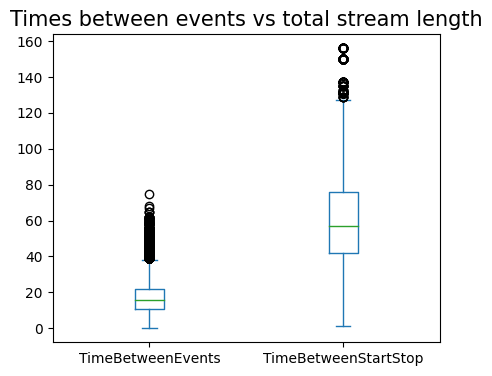

In [27]:
# StreamEnd means that the end of a stream is reached.
# However, there are waypoints between start-end, end-end, end-stop.
# Time between events on average is ~18 min, while total length ~58 min.
contains_start = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamstart' in x)
contains_end = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamend' in x)
contains_stop = df_media_users_grouped['EventTypeList'].apply(lambda x: 'streamstop' in x)

# plot difference in time between events, and total length, i.e. start-stop.
_, ax = plt.subplots(figsize=(5,4))
df_start_end_stop = df_media_users_grouped[contains_start & contains_end & contains_stop]
df_start_end_stop["TimeBetweenEvents"] = df_start_end_stop["EventTimesList"].apply(lambda x: np.array(x)).apply(lambda x: (x[1:] - x[:-1]).mean().total_seconds() // 60)
df_start_end_stop["TimeBetweenStartStop"] = df_start_end_stop["EventTimesList"].apply(lambda x: np.array(x)).apply(lambda x: (x[-1] - x[0]).total_seconds() // 60)
df_start_end_stop.plot.box(column=["TimeBetweenEvents", "TimeBetweenStartStop"], ax = ax)
ax.set_title("Times between events vs total stream length", fontsize=FONTSIZE);

In [28]:
# filter out if start and stop are not in EventType, 
# because stream length, i.e. time between start and stop, will be used for the rating
df_media_users_grouped = df_media_users_grouped[contains_start & contains_stop]

In [29]:
# continue with the filtered group by object
df = df_media_users_grouped[["MediaId", "UserId", "StreamLength"]]
df.head()

,MediaId,UserId,StreamLength
1,1,2,47.0
2,1,5,47.0
3,1,6,47.0
4,1,10,47.0
5,1,13,35.0


In [30]:
# just checking if streamlength is less than 0
len(df[df["StreamLength"] < 0])

0

In [31]:
df.dtypes

MediaId           int64
UserId            int64
StreamLength    float64
dtype: object

# Key insights 

In [32]:
n_ratings = len(df)
n_media = len(df['MediaId'].unique())
n_users = len(df['UserId'].unique())
  
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique media: {n_media}")
print(f"Number of unique users: {n_users}")
 
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per media: {round(n_ratings/n_media, 2)}")

Number of ratings: 78799
Number of unique media: 1672
Number of unique users: 943
Average ratings per user: 83.56
Average ratings per media: 47.13


In [33]:
# dedicated users
user_freq = df[['UserId', 'MediaId']].groupby('UserId').count().reset_index()
user_freq.columns = ['UserId', 'n_views']
user_freq.sort_values('n_views', ascending=False).head(3)

,UserId,n_views
654,655,670
404,405,669
12,13,500


In [34]:
# popular media 
item_freq = df[['UserId', 'MediaId']].groupby('MediaId').count().reset_index()
item_freq.columns = ['MediaId', 'n_views']
item_freq.sort_values('n_views', ascending=False).head(3)

,MediaId,n_views
293,294,439
287,288,393
257,258,377


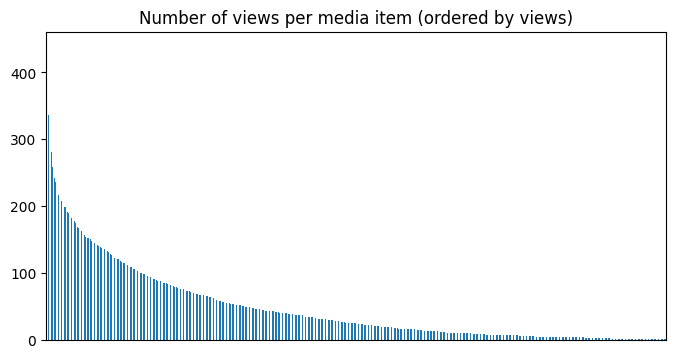

In [36]:
# The distribution of views per media item has a relatively long tale.
# See section "Validation", which checks if popular items will also be recommended more.
_, ax = plt.subplots(figsize=(8, 4))
item_freq.sort_values('n_views', ascending=False)['n_views'].plot.bar(ax=ax, width=.5)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_title('Number of views per media item (ordered by views)');

In [56]:
# Media that are watched very briefly.
# It is watched for only 0 min. Error?
mean_rating = df.groupby('MediaId')[['StreamLength']].mean()
lowest_rated = mean_rating['StreamLength'].idxmin()
lowest_rated_MediaId = df.loc[df['MediaId'] == lowest_rated]['MediaId']
lowest_value = mean_rating['StreamLength'].min()
print(f'Briefly watched MediaId: {lowest_rated_MediaId.unique()} by {len(lowest_rated_MediaId)} users with stream length {lowest_value} min.')

Lowest rated MediaId: [1063] by 29 users with stream length 0.0 min.


In [58]:
# Media that are watched at great length.
highest_rated = mean_rating['StreamLength'].idxmax()
highest_rated_MediaId = df.loc[df['MediaId'] == highest_rated]['MediaId']
highest_value = mean_rating['StreamLength'].max()
print(f'Long watched MediaId: {highest_rated_MediaId.unique()} by {len(highest_rated_MediaId)} users with stream length {highest_value} min.')

Long watched MediaId: [1593] by 1 users with stream length 136.0 min.


# Processing ratings

Text(0.5, 1.0, 'Stream length in minutes')

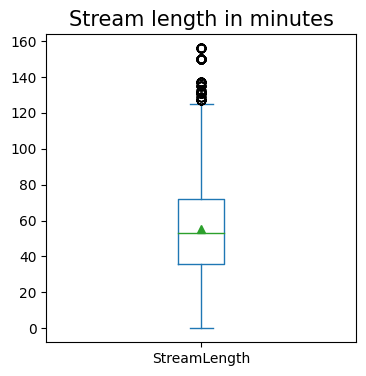

In [59]:
# Outliers are visualized by black circles, indicating that they 
_, ax = plt.subplots(figsize=(4, 4))
df['StreamLength'].plot.box(ax=ax, showmeans=True)
ax.set_title('Stream length in minutes', fontsize=FONTSIZE)

In [60]:
stats = df['StreamLength'].describe()
stats

count    78799.000000
mean        55.154190
std         26.025976
min          0.000000
25%         36.000000
50%         53.000000
75%         72.000000
max        156.000000
Name: StreamLength, dtype: float64

In [61]:
# outliers can happen due to errors in data collection
# they can also distort the similarity computation

# Calculate the boundaries for outliers
q1 = stats['25%']
q3 = stats['75%']
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
df = df[(df['StreamLength'] >= lower_bound) & (df['StreamLength'] <= upper_bound)]

In [62]:
df = df.rename(columns={"StreamLength": "Rating"})

Text(0.5, 1.0, 'Rating')

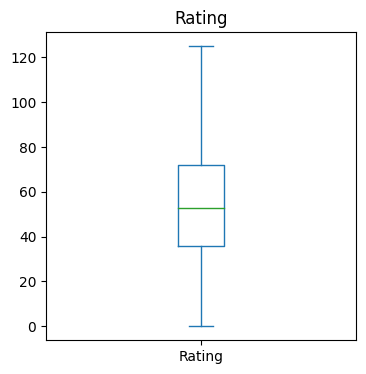

In [63]:
_, ax = plt.subplots(figsize=(4, 4))
df["Rating"].plot.box(ax=ax)
ax.set_title("Rating")

# Item-to-item collaborative filter
A [kNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html) will find similar items based on the ratings from users.
- Metric: The similarity metric will be the 'cosine distance', because unlike the 'euclidean distance', the angle doesn't change with the user vector's length. So, if two media items differ in total video length, that won't affect the rating. It's also suitable for floats (whereas 'Jaccard similarity' is suitable for booleans, i.e. mediaItem watched yes/no).
- Algorithm: 'Ball-tree' is more efficient than 'brute' for structering the data to compute the neighbours, and, unlike a 'KD-tree' is suitable for high-dimensional data.

👆 Note:
- kNN requires to store the item-user matrix, which can take up a lot of memory. Alternative methods use matrix vectorization to prevent this. 
- Popularity bias can occur when items that are frequently viewed are also recommended more often, because they appear more similar to other items. A way to mitigate this is to substitue 0's by the average rating or to use the 'centered cosine'.

In [65]:
# We need a mapper because we cannot use Id's as indices
print(df["UserId"].max(), len(df["UserId"].unique()))
print(df["MediaId"].max(), len(df["MediaId"].unique()))

943 943
1682 1671


In [66]:
def create_matrix(df: pd.DataFrame):
    """
    Create compressed Sparse Row matrix with M-item-rows and N-user-columns.
    Media and User mappers are used to map id's to indices.
    params: pd.DataFrame
    returns: scipy.sparse.csr_matrix for the compressed matrix, and the mappings (dict)
    """
    N = len(df['UserId'].unique())
    M = len(df['MediaId'].unique())

    # Map Ids to indices
    user_mapper = dict(zip(np.unique(df["UserId"]), list(range(N))))
    media_mapper = dict(zip(np.unique(df["MediaId"]), list(range(M))))

    # Map indices to IDs
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["UserId"])))
    media_inv_mapper = dict(zip(list(range(M)), np.unique(df["MediaId"])))

    user_index = [user_mapper[i] for i in df['UserId']]
    media_index = [media_mapper[i] for i in df['MediaId']]

    X = csr_matrix((df["Rating"], (media_index, user_index)), shape=(M, N))

    return X, user_mapper, media_mapper, user_inv_mapper, media_inv_mapper

In [68]:
def get_dimension_reduction_model(X, k, metric='cosine'):
    """
    Trains a k-nearest neighbors algorithm to reduce the dimension of csr matrix.
    """
    k += 1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="auto", metric=metric)
    kNN.fit(X)
    return kNN

In [69]:
k = 10

X, user_mapper, media_mapper, user_inv_mapper, media_inv_mapper = create_matrix(df)
model = get_dimension_reduction_model(X, k)

# These are required to find similiar items.
model.media_mapper = media_mapper
model.media_inv_mapper = media_inv_mapper

In [70]:
joblib.dump(model, 'final_model.joblib')

['final_model.joblib']

# Validation
To check for popularity bias, i.e. the system tends to recommend popular items, we can check if similar items are also the popular items.

In [71]:
def find_similar_items(item_id: int, model: NearestNeighbors, k: int):
    """
    Find similar items using KNN.
    :param item_id: The id of the item
    :param model: A dimension reduction model used to find similar items
    :param k: The number of similar items returned.
    :returns List with similar ids
    """
    neighbour_ids = []

    item_id = model.media_mapper[item_id]
    item_vec = model._fit_X[item_id]
    k += 1
    item_vec = item_vec.reshape(1, -1)
    neighbour = model.kneighbors(item_vec, return_distance=False)

    for i in range(k):
        n = neighbour.item(i)
        neighbour_ids.append(model.media_inv_mapper[n])
    # We don't want to recommend this item_id itself
    neighbour_ids.pop(0)
    return neighbour_ids[:k]

In [72]:
# given all possible items, compute similar items by the model
k = 3
similar_items = []

for media_id in media_mapper.keys():
    similar_ids = find_similar_items(media_id, model, k)
    similar_items.extend(similar_ids)

In [73]:
# most recommended media by model
[k for k,v in Counter(similar_items).most_common()[:5]]

[204, 1557, 1575, 1587, 405]

In [74]:
# most popular media by views
item_freq.sort_values('n_views', ascending=False)["MediaId"].values[:5]

array([294, 288, 258, 121, 286])

Conclusion: The top 5 most popular items, are not in the list of recommended items.